# Diffusion equation

Solve
$$
\partial_t c = D \partial_x^2 c  - k (c-c_o)
$$
on the interval $x \in [-\pi, \pi]$ with Neumann boundary conditions $\partial_x c |_{x=-\pi} = 0 = \partial_x c |_{x=\pi}$, and the initial condition $c(x,0) = c_i(x)$. The exact solution for this problem would be
$$
c_e(x,t) = c_o + \sum_{n \in \mathbb{Z}} c_n(0) e^{-(Dn^2 + k)t} \cos nx
$$

In [20]:
#importing necessary libraries
%matplotlib ipympl
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import Slider

import dolfinx as dfx
from mpi4py import MPI
import ufl, basix
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.fem.petsc import LinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx import fem, mesh, io, plot

## Defining parameters

We define the various parameters, the diffusion constant D, the advection constant k, the mode m, the initial condition that determines the amplitude a and co as some steady concentration. The length of the domain is defined by L and the number of divisions of the domain is given by n. The time of the diffusion is given by T with time steps dt. 

In [21]:
m, co, a = 1, 1, 0.1
L, n, dt, T = np.pi, 32, 0.05, 1
D, k = 1, 5

We create a 1-D domain with n intervals of length 2L. x gives the parameterized co-ordinates corresponding to this domain

In [22]:
domain = dfx.mesh.create_interval(MPI.COMM_WORLD, n, [-L,L])
x = domain.geometry.x[:,0]


We create elements of largrange polynomials for each cell of degree 1. We then create a function space of scalar type on the domain.

In [23]:
scalar_element = basix.ufl.element("P", domain.basix_cell(), 1)
SFS = dfx.fem.functionspace(domain, scalar_element)


We now create specific functions on the function space given by c,c0 and a test function tc.

In [24]:
c = dfx.fem.Function(SFS)
c0 = dfx.fem.Function(SFS)
tc = ufl.TestFunction(SFS)

The initial concentration at t=0 is given by the below function of the co-ordinates.

In [25]:
c0.interpolate(lambda x : co + a * np.cos(m*x[0]))

The next step is to write down the weak form. We use implicit euler nethod to write down the weak form. We assume proper boundary conditions and transfer one of the derivatives tc by a partial integration. 
$$
    \int dl <c-c0,tc>/dt = D \int dl<\nabla^2 c,tc> - \int dl k<c-co,tc> ,\\
    \int dl <c-c0,tc>/dt = -D \int dl<\nabla c,\nabla tc> - \int dl k<c-co,tc> 
$$

In [26]:
# weak form
form = (ufl.inner( (c-c0)/dt, tc) + D * ufl.inner(ufl.grad(c), ufl.grad(tc)) + k * ufl.inner(c-co, tc)
       ) * ufl.dx

The solution for c is to be found for the above form=0 by NewtonSolver method (root finding method) 

In [27]:
problem = NonlinearProblem(form, c)
solver = NewtonSolver(MPI.COMM_WORLD, problem)

We define the time array as per our time interval. We then define an array to store the consentration for the whole domain for each time step. Then we put the 1st value of c for t=0 as the initial c (c0).

In [28]:
times = np.linspace(0, T, int(T/dt)+1)
carray = np.zeros((len(times), len(x)))
carray[0] = c0.x.array[:]

We run over the time steps and solve for c at each time step. The implicit euler depends on the previous value of c which we store in c0 (update it). We also append the concentration c to the carray at each time step.

In [29]:
for tt in range(1, len(times)):
    solver.solve(c)
    c0.x.array[:] = c.x.array[:]
    carray[tt] = c.x.array[:]

The exact solution is given by the following function of co-ordinates.

In [30]:
cexact = lambda x, t : co + a * np.cos(m*x) * np.exp(-(D*m**2 + k) * t)

Now we define the plotting function. We create a figure object with a size (8,4) and set its x-axis and y-axis as the x-domain range and max and min of concentration respectively. We then proceed to plot the numerical and exact solution. We then added a slider over time that calls the update function as the slider is changed to update c to different time steps and plot it.

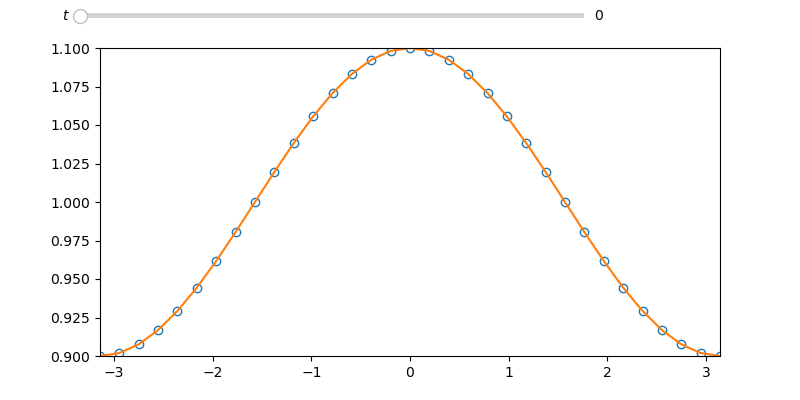

In [31]:
plt.close('all')
fig, ax = plt.subplots(1, figsize=(8,4))
ax.set_xlim(-L, L)
ax.set_ylim(carray.min(), carray.max())
cplot, = ax.plot(x, carray[0], 'o', mfc='none')
ceplot, = ax.plot(x, cexact(x, 0), '-')

axs = fig.add_axes([0.1, 0.95, 0.63, 0.0225])
slider = Slider(
        ax=axs,
        label=r"$t$",
        valmin=0, valmax=10*T,
        valinit=0
    )

def update(t):
    ti = (abs(times-t)).argmin()
    cplot.set_ydata(carray[ti])
    ceplot.set_ydata(cexact(x, times[ti]))
    fig.canvas.draw_idle()
slider.on_changed(update)

plt.show()